In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize as sp_minimize
%matplotlib inline

In [3]:
from Likelihood import Model, ModelFactory
from Likelihood import Profile_likelihood_ratio_result

In [4]:
n_data = 10000
mu = 0.
sigma = 1.
np.random.seed(1)
data = np.random.normal(mu, sigma, n_data)

In [5]:
model = Model()
model.debug_level = 0
model.set_data(data)
model.set_score_function('m2_log_likelihood_gaus')

In [6]:
model.profile_likelihood_ratio_ci()
model.compute_common_stat_on_data()
model.profile_likelihood_ratio_curve()
res = model.plr_res

::: Minimization Failed in unconstraint_fit!!!!!!
      fun: 28354.472784155514
 hess_inv: array([[  5.43903990e-05,  -1.67376867e-06],
       [ -1.67376867e-06,   2.16476506e-05]])
      jac: array([ 0.00024414,  0.00048828])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 124
      nit: 11
     njev: 28
   status: 2
  success: False
        x: array([ 0.00977266,  0.99878585])
::: Minimization Failed in unconstraint_fit!!!!!!
      fun: 28354.472784155514
 hess_inv: array([[  5.43903990e-05,  -1.67376867e-06],
       [ -1.67376867e-06,   2.16476506e-05]])
      jac: array([ 0.00024414,  0.00048828])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 124
      nit: 11
     njev: 28
   status: 2
  success: False
        x: array([ 0.00977266,  0.99878585])


Likelihood.py:88: RuntimeWarning: invalid value encountered in log
  f1 = 2 * self.n_data * ( np.log(params[1]) + self.log_sqrt_2pi)


/home/renaud/anaconda2/envs/main_env/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


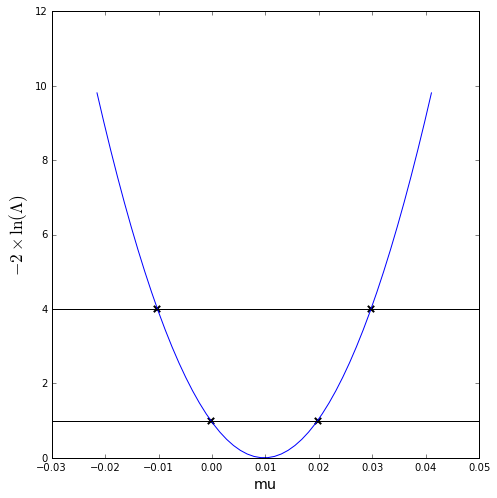

In [7]:
from Likelihood import Profile_likelihood_ratio_result
res.plot_profile_likehood_curve_and_ci()

(array([ 0.01976047, -0.00021516]), array([ 1.,  1.]))
(array([ 0.02975163, -0.01020631]), array([ 4.,  4.]))


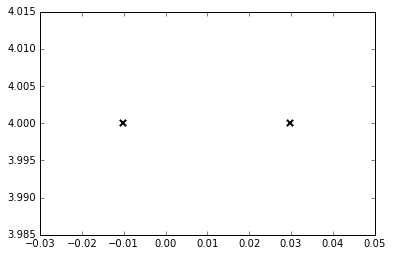

In [8]:
## need to use deg=3 and filter values outside x range
def quadratic_intersections(p, q):
    """Given two quadratics p and q, determines the points of intersection"""
    x = np.roots(np.asarray(p) - np.asarray(q))
    y = np.polyval(p, x)
    return x, y

poly = np.polyfit(res.pois, res.plr, deg=2)
y_int  = np.polyval(poly, res.pois)
ix_1 = quadratic_intersections(poly, [ 0, 0, 1])
ix_4 = quadratic_intersections(poly, [ 0, 0, 4])
plt.scatter(*ix_4, marker='x', color='black', s=40, linewidth=2)
print ix_1
print ix_4

In [ ]:
for i in range(1000):

In [17]:
if not 2000%10:
    print 'toto'

toto


In [16]:
1000%10

0

In [18]:
A = np.random.random((64,48))

@dview.parallel(block=True)
def pmul(A,B):
     return A*B
C_local = A*A

C_remote = pmul(A,A)
(C_local == C_remote).all()


NameError: name 'dview' is not defined

In [22]:
from IPython.Ipyparallel import Client

ImportError: No module named Ipyparallel